In [1]:
library(magrittr)
library(tidyverse)
source("../data/env/variables.R")
source("../wisdom/code/r/clean_theme.R")

options("readr.num_columns" = 0)

# read consensus, not noise, switches
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1)
switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(EnoughRecurrence == 1 & NotNoise==1 & IsModel==1 & Origin=="Tumor")

# read mutations
wes <- read_tsv("../data/mutations/wes_mutations.txt") %>% 
    select(Tumor,GeneId,Symbol,Patient) %>% 
    unique
wgs <- read_tsv("../data/mutations/wgs_mutations.txt") %>% 
    select(Tumor,GeneId,Symbol,Patient) %>% 
    unique

# Read IntoGene mutational drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>% 
    select(geneHGNCsymbol) %>%
    unique

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


## Some stats about switches

In [2]:
# num switches
nrow(switches)

# num genes
switches %>% select(GeneId,Symbol) %>% unique %>% nrow

[1] 8122

[1] 6442

In [3]:
# Numbers
cdsNormal <- as.logical(switches$CDS_Normal)
cdsTumor <- as.logical(switches$CDS_Tumor)
functional <- as.logical(switches$IsFunctional)

# any functional
sum(functional)

[1] 6004

In [4]:
# two protein coding isoforms
sum(cdsNormal & cdsTumor)
# percentage
sum(cdsNormal & cdsTumor)/nrow(switches) * 100

[1] 6937

[1] 85.41

In [5]:
# functional & two protein coding isoforms
sum(functional & cdsNormal & cdsTumor)
# percentage
sum(functional & cdsNormal & cdsTumor)/nrow(switches) * 100

[1] 5047

[1] 62.13987

In [6]:
# only normal isoform
sum(cdsNormal & !cdsTumor)
# percentage
sum(cdsNormal & !cdsTumor)/nrow(switches) * 100

[1] 732

[1] 9.012558

In [7]:
# only tumor isoform
sum(!cdsNormal & cdsTumor)
# percentage
sum(!cdsNormal & cdsTumor)/nrow(switches) * 100

[1] 231

[1] 2.844127

In [8]:
# two protein coding isoforms & functional
sum(cdsNormal & cdsTumor & functional)
# percentage
sum(cdsNormal & cdsTumor & functional)/sum(cdsNormal & cdsTumor) * 100

[1] 5047

[1] 72.75479

In [9]:
# unbalance between only niso and only tiso
x <- sum(cdsNormal & !cdsTumor)
n <- sum(!cdsNormal & cdsTumor)+sum(cdsNormal & !cdsTumor)
binom.test(x,n,0.5)


	Exact binomial test

data:  x and n
number of successes = 732, number of trials = 963, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.7318644 0.7867841
sample estimates:
probability of success 
             0.7601246 


## Stats about patient recurrence

### Differences between functional and non-functional

Loading required package: RColorBrewer



	Wilcoxon rank sum test with continuity correction

data:  pats.fun and pats.nonFun
W = 5970800, p-value = 2.933e-05
alternative hypothesis: true location shift is not equal to 0


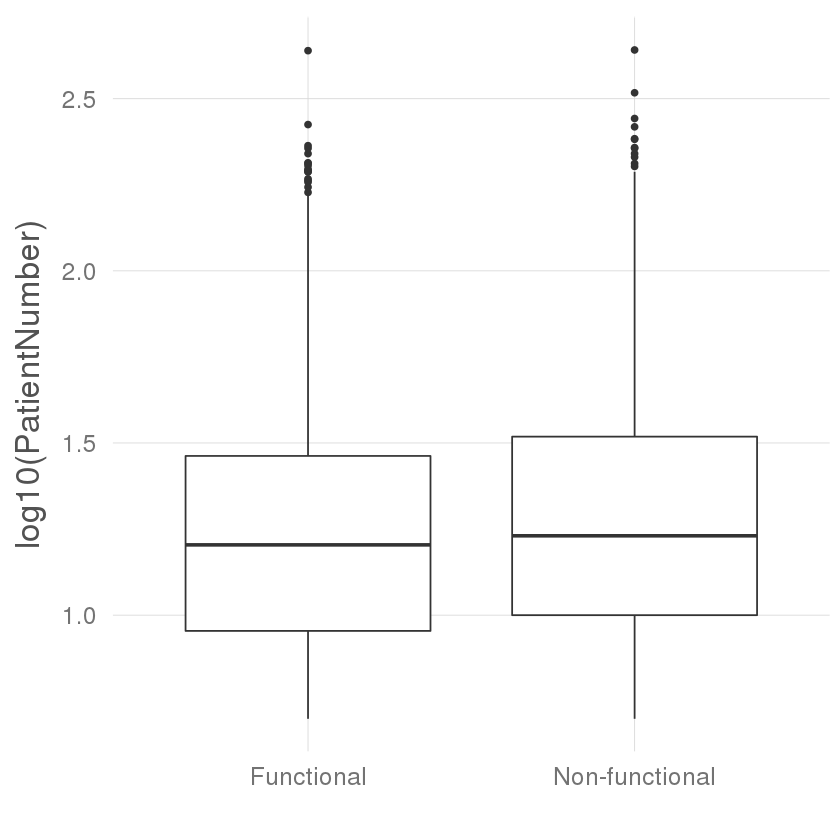

In [10]:
switches %>%
    mutate(Functional = ifelse(IsFunctional==1, "Functional", "Non-functional")) %>%
    ggplot(aes(y=log10(PatientNumber),x=Functional)) +
        geom_boxplot() + 
        clean_theme() +
        labs(x="")

pats.fun <- switches$PatientNumber[switches$IsFunctional==1]
pats.nonFun <- switches$PatientNumber[switches$IsFunctional==0]
wilcox.test(pats.fun,pats.nonFun)

### Comparison to mutation data
We will use mutation data to put switch data into context.

#### Number of alterations per patient

In [11]:
# count number of genes altered per patient
## WES mutation
genesPAM.perPatient <- wes %>%
    group_by(Tumor,Patient) %>%
    summarise(PAM=n())

## WGS mutation
genesMutated.perPatient <- wgs %>%
    group_by(Tumor,Patient) %>%
    summarise(WGS=n())

## a functional switch
genesSwitched.perPatient <- switches$Patients_affected[switches$IsFunctional==1] %>%
    strsplit(",") %>% unlist %>%
    table %>% as.data.frame %>%
    set_colnames(c("Patient","Switch"))

# use number of spliced genes and total number of genes to normalize the observations
lines <- "Tumor\tSplicedGenes\tGenes\nbrca\t12383\t20530\nprad\t11849\t20530\nthca\t11812\t20530\ncoad\t11498\t20530\nhnsc\t11583\t20530\nkich\t11607\t20530\nkirc\t12205\t20530\nkirp\t11853\t20530\nlihc\t10490\t20530\nluad\t12046\t20530\nlusc\t12070\t20530\n"
consideredGenes <- read_tsv(lines) %>%
    set_colnames(c("Tumor","SplicedGenes","Genes"))

recurrence <- merge(genesSwitched.perPatient,genesPAM.perPatient,all=T) %>%
    merge(genesMutated.perPatient,all=T) %>%
    merge(consideredGenes) %>%
    mutate(PAM=PAM/Genes, WGS=WGS/Genes,
           Switch=Switch/SplicedGenes) %>%
    select(everything(),-contains("Genes"))

Warning message:
“Removed 4547 rows containing non-finite values (stat_boxplot).”

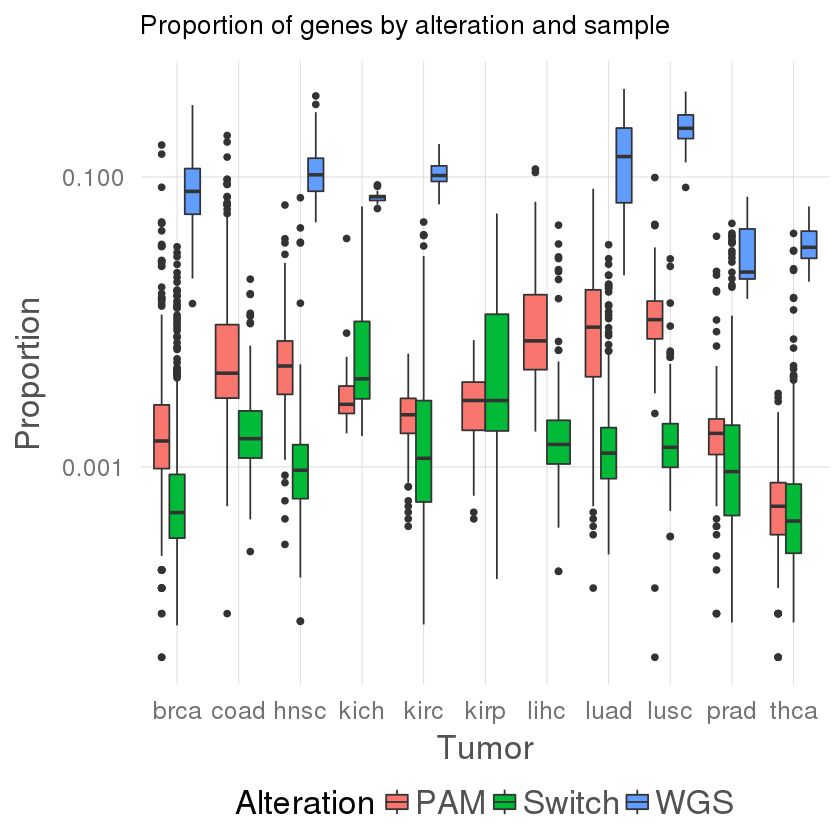

In [12]:
# show distribution of genes affected through each mechanism per patient
recurrence %>%
    gather(Tumor,Patient) %>%
    set_colnames(c("Tumor","Patient","Alteration","Proportion")) %>%
    ggplot(aes(x=Tumor,y=Proportion, fill=Alteration)) +
        geom_boxplot() + 
        clean_theme() +
        scale_y_log10() +
        theme(legend.position="bottom", plot.title = element_text(size=16)) +
        labs(title="Proportion of genes by alteration and sample")

Warning message:
“Removed 486 rows containing missing values (geom_point).”

[1] -0.006857664

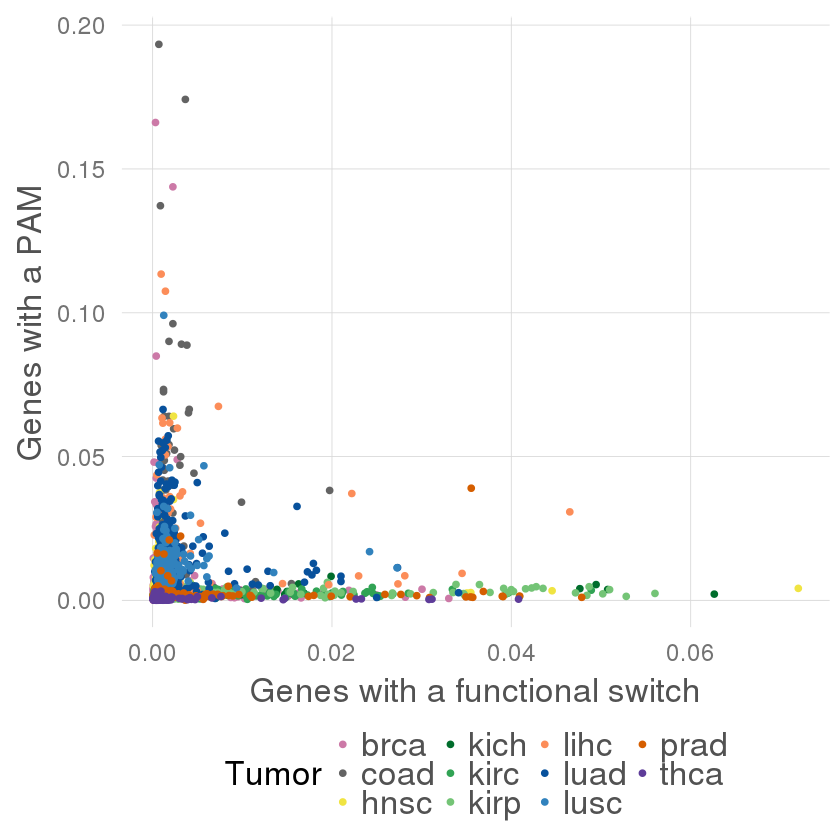

In [13]:
# show lack of correlation between mutations and switches
recurrence %>%
    ggplot(aes(x=Switch,y=PAM)) + 
    geom_point(aes(color=Tumor)) + 
    clean_theme() +
    scale_color_manual(values=colorPalette) + 
    theme(legend.position="bottom") +
    labs(x="Genes with a functional switch", y="Genes with a PAM")

cor(recurrence$PAM, recurrence$Switch, use="complete.obs")

`geom_smooth()` using method = 'gam'
Warning message:
“Removed 486 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 486 rows containing missing values (geom_point).”

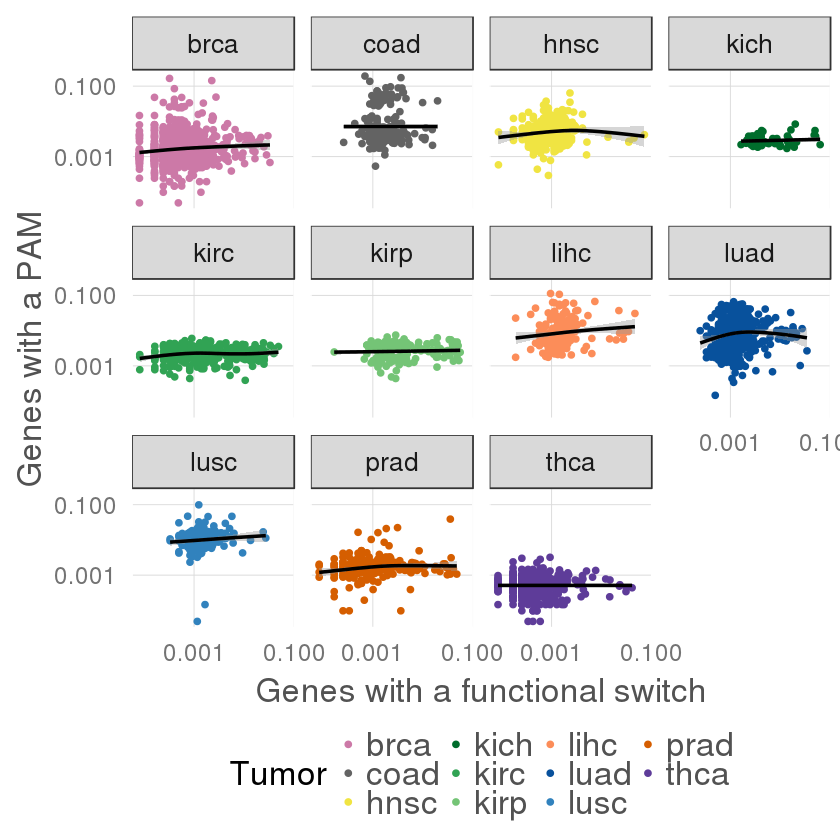

In [14]:
recurrence %>%
    ggplot(aes(x=Switch,y=PAM,color=Tumor)) + 
    geom_point() + 
    geom_smooth(color="black") +
    clean_theme() +
    scale_y_log10() +
    scale_x_log10() +
    scale_color_manual(values=colorPalette) + 
    theme(legend.position="bottom") +
    labs(x="Genes with a functional switch", y="Genes with a PAM") + 
    facet_wrap(~ Tumor)

#### Number of altered samples per gene

In [15]:
# count number of genes altered per patient
## WES mutation
samplesPAM.perGene <- wes %>%
    group_by(Tumor,GeneId) %>%
    summarise(PAM = n())

## WGS mutation
samplesMutated.perGene <- wgs %>%
    group_by(Tumor,GeneId) %>%
    summarise(WGS = n())

## a functional switch
samplesSwitched.perGene <- switches.split %>%
    filter(IsFunctional==1) %>%
    select(Tumor,GeneId,PatientNumber) %>%
    group_by(Tumor,GeneId) %>%
    summarise(Switch=sum(PatientNumber)) %>%
    set_colnames(c("Tumor","GeneId","Switch"))

# use number of patients per tumor to normalize the observations
wesPatients <-  wes %>%
    select(Tumor,Patient) %>% unique %>%
    group_by(Tumor) %>%
    summarise(WESPatients = n())

wgsPatients <-  wgs %>%
    select(Tumor,Patient) %>% unique %>%
    group_by(Tumor) %>%
    summarise(WGSPatients = n())

splicingPatients <- do.call("rbind",nPatients) %>%
    as.data.frame %>%
    set_colnames("SplicingPatients") %>%
    mutate(.,Tumor=rownames(.)) %>%
    filter(Tumor!="total")

patients <- merge(wesPatients,wgsPatients,all=T) %>%
    merge(splicingPatients,all=T)

geneIncidence <- merge(samplesSwitched.perGene,samplesPAM.perGene,all=T) %>%
    merge(samplesMutated.perGene,all=T) %>%
    merge(patients) %>%
    mutate(PAM=PAM/WESPatients, WGS=WGS/WGSPatients,
           Switch=Switch/SplicingPatients) %>%
    select(everything(),-contains("Patients"))

Warning message:
“Removed 250752 rows containing non-finite values (stat_boxplot).”

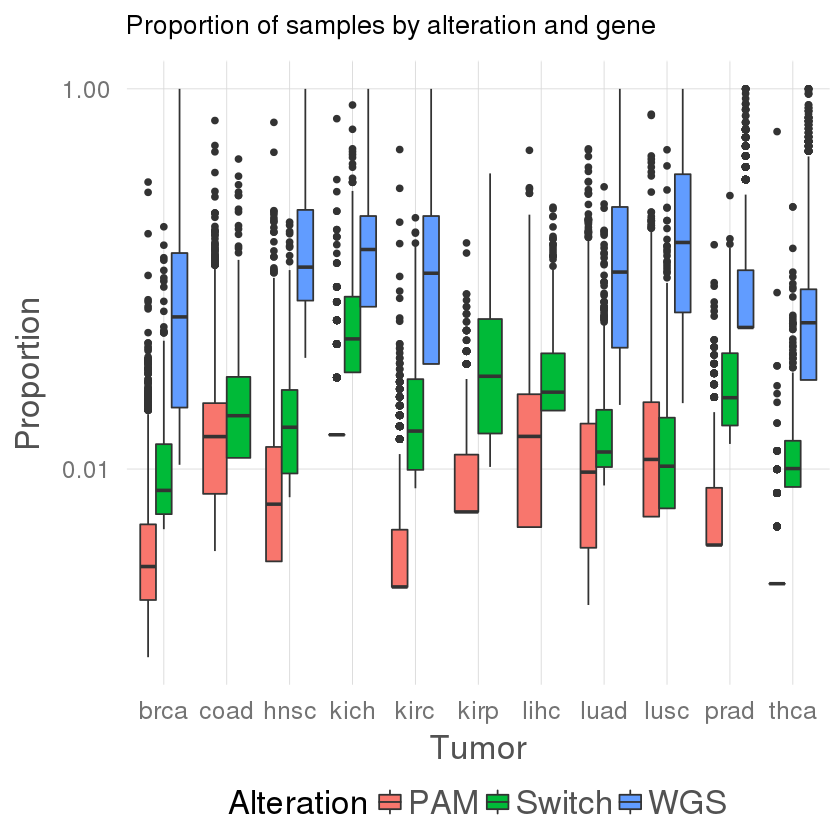

In [16]:
# show distribution of samples affected through each mechanism per gene
geneIncidence %>%
    gather(Tumor,GeneId) %>%
    set_colnames(c("Tumor","GeneId","Alteration","Proportion")) %>%
    ggplot(aes(x=Tumor,y=Proportion, fill=Alteration)) +
        geom_boxplot() + 
        clean_theme() +
        scale_y_log10() +
        theme(legend.position="bottom", plot.title = element_text(size=16)) +
        labs(title="Proportion of samples by alteration and gene",y="Proportion")

#### Pancancer comparison

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 1703 rows containing non-finite values (stat_ydensity).”

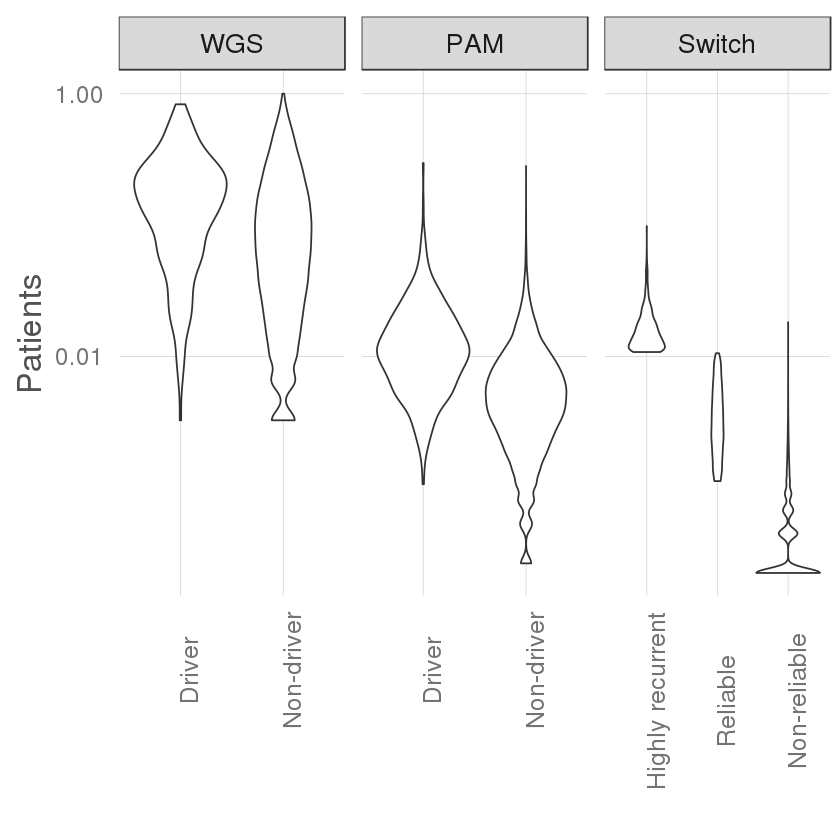

In [17]:
# Calculate number of patients
wesPatients <-  wes$Patient %>% unique %>% length
wgsPatients <-  wgs$Patient %>% unique %>% length
splicingPatients <- nPatients$total

# Annotate switches
s <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(IsFunctional == 1 & Origin == "Tumor") %>%
    mutate(Alteration = "Switch",
           Annotation = ifelse(Reliable==1, "Reliable", "Non-reliable"),
           Annotation = ifelse(Reliable==1 & Recurrence==1, "Highly recurrent", Annotation),
           PatientNumber = PatientNumber/splicingPatients) %>%
    arrange(Annotation,desc(PatientNumber)) %>%
    select(Alteration,Annotation,PatientNumber)

# count number of genes altered per patient
## WES mutation
samplesPAM.perGene <- wes %>%
    group_by(Tumor,GeneId,Symbol) %>%
    summarise(PAM = n())

## WGS mutation
samplesMutated.perGene <- wgs %>%
    group_by(Tumor,GeneId,Symbol) %>%
    summarise(WGS = n())

m <- merge(samplesMutated.perGene,samplesPAM.perGene,all=T) %>% 
    group_by(GeneId,Symbol) %>%
    summarise(WGS=sum(WGS,na.rm=T)/wgsPatients, 
              PAM=sum(PAM,na.rm=T)/wesPatients) %>%
    ungroup %>%
    select(Symbol,WGS,PAM) %>% as.data.frame %>%
    gather(Symbol) %>%
    set_colnames(c("Symbol","Alteration","PatientNumber")) %>%
    mutate(Annotation = ifelse(Symbol %in% drivers$geneHGNCsymbol, "Driver", "Non-driver")) %>%
    select(Alteration,Annotation,PatientNumber)

rbind(m,s) %>%
    mutate(PatientNumber=as.numeric(PatientNumber),
           Annotation = factor(Annotation,
                               levels = c("Highly recurrent","Reliable","Non-reliable","Driver","Non-driver")),
           Alteration = factor(Alteration, levels = c("WGS", "PAM", "Switch"))) %>%
    ggplot(aes(x=Annotation,y=PatientNumber)) +
        geom_violin() +
        clean_theme() + 
        theme(legend.position="bottom", axis.text.x=element_text(angle=90)) +
        labs(y="Patients",x="") +
        scale_y_log10() +
        facet_grid(.~Alteration,scales="free_x")

## Stats about co-ocurrence

In [18]:
# number of functional switches with co-occurrence
sum(switches$p.mut.o[switches$IsFunctional==1] < 0.05, na.rm=T)

# number of switches with co-occurrence
sum(switches$p.mut.o < 0.05, na.rm=T)
sum(switches$p.mut.o < 0.05, na.rm=T)/nrow(switches)*100

[1] 16

[1] 21

[1] 0.258557